<a href="https://colab.research.google.com/github/samhitaveluri/driver_alert/blob/main/Copy_of_IC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import keras
import os
from zipfile import ZipFile
import matplotlib.pyplot as plt
import cv2
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from sklearn.metrics import classification_report


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
with ZipFile("/content/drive/MyDrive/dset.zip", 'r') as zObject:
    zObject.extractall(path="/content/drive/MyDrive/Java")

with ZipFile("/content/drive/MyDrive/archive (4).zip", 'r') as zObject:
    zObject.extractall(path="/content/drive/MyDrive/Java")

In [ ]:
labels = os.listdir("/content/drive/MyDrive/Java/train")

In [ ]:
labels

['Closed', 'Open', 'no_yawn', 'yawn']

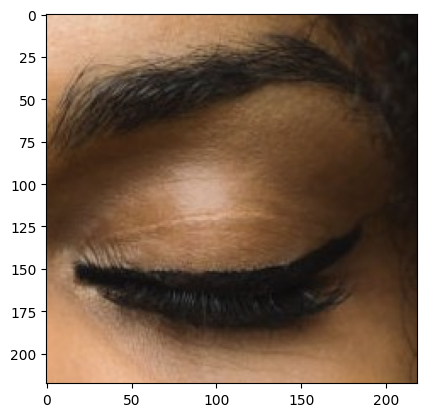

In [ ]:
plt.imshow(plt.imread("/content/drive/MyDrive/Java/train/Closed/_119.jpg"))

In [ ]:
a = plt.imread("/content/drive/MyDrive/Java/train/yawn/10.jpg")

In [ ]:
a.shape


(480, 640, 3)

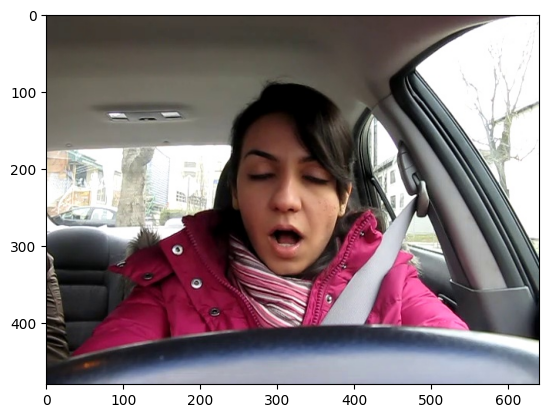

In [ ]:
plt.imshow(plt.imread("/content/drive/MyDrive/Java/train/yawn/17.jpg"))


In [ ]:
def face_for_yawn(direc="/content/drive/MyDrive/Java/train", face_cas_path="/content/drive/MyDrive/Java/haarcascade_frontalface_default.xml"):
    yaw_no = []
    IMG_SIZE = 145
    categories = ["yawn", "no_yawn"]
    for category in categories:
        path_link = os.path.join(direc, category)
        class_num1 = categories.index(category)
        print(class_num1)
        for image in os.listdir(path_link):
            image_array = cv2.imread(os.path.join(path_link, image), cv2.IMREAD_COLOR)
            face_cascade = cv2.CascadeClassifier(face_cas_path)
            faces = face_cascade.detectMultiScale(image_array, 1.3, 5)
            for (x, y, w, h) in faces:
                img = cv2.rectangle(image_array, (x, y), (x+w, y+h), (0, 255, 0), 2)
                roi_color = img[y:y+h, x:x+w]
                resized_array = cv2.resize(roi_color, (IMG_SIZE, IMG_SIZE))
                yaw_no.append([resized_array, class_num1])
    return yaw_no


yawn_no_yawn = face_for_yawn()


0
1


In [ ]:


def crop_eye(image_path):
    image = cv2.imread(image_path)

    if image is None:
        print("Failed to load the image.")
        return None

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')

    eyes = eye_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    if len(eyes) > 0:
        (x, y, w, h) = eyes[0]
        cropped_eye = image[y:y+h, x:x+w]

        resized_eye = cv2.resize(cropped_eye, (145, 145))

        normalized_eye = resized_eye / 255.0
        input_data = normalized_eye.reshape(1, 145, 145, 3)

        plt.imshow(cv2.cvtColor(cropped_eye, cv2.COLOR_BGR2RGB))
        plt.title("Cropped Eye")
        plt.axis('off')
        plt.show()

        return cropped_eye

    return None

image_path = "train/yawn/17.jpg"
cropped_eye = crop_eye(image_path)

Failed to load the image.


In [ ]:
def get_data(dir_path, face_cas, eye_cas):
    labels = ['Closed', 'Open']
    IMG_SIZE = 145
    data = []
    for label in labels:
        path = os.path.join(dir_path, label)
        class_num = labels.index(label)
        class_num +=2
        print(class_num)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
                resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                data.append([resized_array, class_num])
            except Exception as e:
                print(e)
    return data

In [ ]:
data_train=get_data("/content/drive/MyDrive/Java/train/","/content/drive/MyDrive/Java/haarcascade_frontalface_default.xml", "/content/drive/MyDrive/Java/haarcascade.xml")

2
3
OpenCV(4.8.0) /io/opencv/modules/imgproc/src/resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



In [ ]:
def append_data():
    yaw_no = face_for_yawn()
    data = get_data()
    yaw_no.extend(data)
    return np.array(yaw_no)

In [ ]:
def append_data():
    dir_path = "train/"
    face_cas = "haarcascade_frontalface_default.xml"
    eye_cas ="haarcascade.xml"

    yaw_no = face_for_yawn()
    data = get_data(dir_path, face_cas, eye_cas)

    yaw_no.extend(data)
    return np.array(yaw_no)

new_data = append_data()

X = []
y = []

for feature, label in new_data:
    X.append(feature)
    y.append(label)

0
1
2
3


<ipython-input-17-3ab2eeca51e5>:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(yaw_no)


In [ ]:
X = np.array(X)
X = X.reshape(-1, 145, 145, 3)

In [ ]:
label_bin = LabelBinarizer()
y = label_bin.fit_transform(y)

In [ ]:
y = np.array(y)

In [ ]:
seed = 42
test_size = 0.30
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, test_size=test_size)

In [ ]:
len(X_test)


578

In [ ]:
train_generator = ImageDataGenerator(rescale=1/255, zoom_range=0.2, horizontal_flip=True, rotation_range=30)
test_generator = ImageDataGenerator(rescale=1/255)

train_generator = train_generator.flow(np.array(X_train), y_train, shuffle=False)
test_generator = test_generator.flow(np.array(X_test), y_test, shuffle=False)

In [ ]:
model = Sequential()

model.add(Conv2D(256, (3, 3), activation="relu", input_shape=X_train.shape[1:]))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(128, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(32, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(64, activation="relu"))
model.add(Dense(4, activation="softmax"))

model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer="adam")

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 143, 143, 256)     7168      
                                                                 
 max_pooling2d (MaxPooling2  (None, 71, 71, 256)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 69, 69, 128)       295040    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 34, 34, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        73792     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 16, 16, 64)        0

In [ ]:
history = model.fit(train_generator, epochs=50, validation_data=test_generator, shuffle=True, validation_steps=len(test_generator))

Epoch 1/50
43/43 [==============================] - 23s 229ms/step - loss: 1.0734 - accuracy: 0.4981 - val_loss: 0.7094 - val_accuracy: 0.7439
Epoch 2/50
43/43 [==============================] - 8s 179ms/step - loss: 0.5173 - accuracy: 0.7936 - val_loss: 0.3659 - val_accuracy: 0.8547
Epoch 3/50
43/43 [==============================] - 9s 213ms/step - loss: 0.4516 - accuracy: 0.8211 - val_loss: 0.3019 - val_accuracy: 0.9031
Epoch 4/50
43/43 [==============================] - 9s 218ms/step - loss: 0.4007 - accuracy: 0.8293 - val_loss: 0.3871 - val_accuracy: 0.8374
Epoch 5/50
43/43 [==============================] - 8s 179ms/step - loss: 0.3677 - accuracy: 0.8419 - val_loss: 0.2714 - val_accuracy: 0.9118
Epoch 6/50
43/43 [==============================] - 8s 185ms/step - loss: 0.3372 - accuracy: 0.8500 - val_loss: 0.2834 - val_accuracy: 0.8858
Epoch 7/50
43/43 [==============================] - 9s 212ms/step - loss: 0.3432 - accuracy: 0.8515 - val_loss: 0.2165 - val_accuracy: 0.9221
Epoch

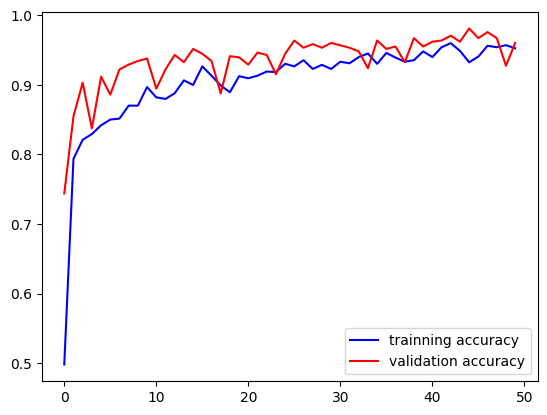

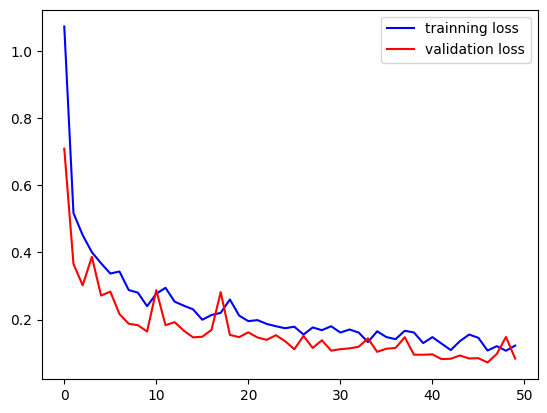

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, "b", label="trainning accuracy")
plt.plot(epochs, val_accuracy, "r", label="validation accuracy")
plt.legend()
plt.show()

plt.plot(epochs, loss, "b", label="trainning loss")
plt.plot(epochs, val_loss, "r", label="validation loss")
plt.legend()
plt.show()

In [ ]:
model.save("drowiness_new6.h5")


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model.save("drowiness_new6.model")


In [ ]:
predict_x=model.predict(X_test)
prediction=np.argmax(predict_x,axis=1)

19/19 [==============================] - 1s 24ms/step


In [ ]:
prediction

array([3, 3, 2, 3, 1, 3, 3, 2, 1, 2, 3, 3, 3, 2, 2, 2, 3, 0, 0, 3, 3, 3,
       2, 1, 1, 2, 2, 2, 3, 2, 3, 2, 3, 2, 0, 3, 3, 2, 1, 3, 3, 3, 2, 3,
       3, 2, 3, 3, 2, 3, 3, 1, 2, 1, 3, 3, 3, 2, 2, 0, 3, 3, 1, 2, 2, 3,
       2, 3, 2, 2, 1, 3, 3, 3, 2, 0, 0, 3, 1, 3, 2, 0, 3, 2, 2, 2, 2, 0,
       3, 3, 2, 2, 3, 3, 1, 0, 3, 0, 3, 3, 3, 1, 3, 1, 2, 3, 2, 0, 2, 2,
       1, 1, 2, 1, 0, 3, 3, 3, 2, 2, 3, 3, 3, 1, 1, 2, 3, 3, 2, 0, 3, 3,
       1, 3, 0, 2, 3, 3, 2, 1, 2, 2, 2, 0, 3, 3, 3, 3, 2, 0, 3, 3, 3, 3,
       3, 0, 1, 1, 3, 1, 3, 2, 2, 3, 3, 3, 3, 2, 3, 2, 3, 1, 2, 0, 3, 3,
       2, 2, 0, 2, 3, 1, 2, 1, 3, 2, 3, 1, 2, 1, 1, 3, 2, 2, 3, 3, 3, 0,
       3, 2, 3, 1, 2, 0, 0, 1, 2, 3, 2, 0, 3, 1, 2, 2, 2, 2, 1, 3, 1, 1,
       1, 0, 2, 3, 3, 3, 3, 0, 1, 2, 0, 0, 3, 3, 1, 3, 3, 0, 3, 3, 0, 0,
       0, 0, 3, 3, 3, 3, 3, 2, 3, 3, 2, 3, 2, 0, 2, 2, 2, 0, 3, 3, 2, 2,
       3, 2, 2, 0, 2, 3, 2, 2, 2, 3, 3, 3, 3, 3, 0, 1, 1, 3, 3, 3, 3, 2,
       3, 1, 2, 2, 2, 3, 2, 0, 2, 2, 1, 3, 2, 3, 1,

In [ ]:
labels_new = ["yawn", "no_yawn", "Closed", "Open"]


In [ ]:
print(classification_report(np.argmax(y_test, axis=1), prediction, target_names=labels_new))

              precision    recall  f1-score   support

        yawn       0.93      0.84      0.88        63
     no_yawn       0.87      0.91      0.89        74
      Closed       0.99      0.95      0.97       215
        Open       0.95      0.99      0.97       226

    accuracy                           0.95       578
   macro avg       0.93      0.92      0.93       578
weighted avg       0.95      0.95      0.95       578



In [ ]:
labels_new = ["yawn", "no_yawn", "Closed", "Open"]
IMG_SIZE = 145
def prepare(filepath, face_cas="/haarcascade_frontalface_default.xml"):
    img_array = cv2.imread(filepath, cv2.IMREAD_COLOR)
    img_array = img_array / 255
    resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    return resized_array.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

model = tf.keras.models.load_model("./drowiness_new6.h5")

In [ ]:
resized_eye = cv2.resize(cropped_eye, (145, 145))
normalized_eye = resized_eye / 255.0
input_data = normalized_eye.reshape(1, 145, 145, 3)
prediction = model.predict(input_data)
np.argmax(prediction)

1/1 [==============================] - 0s 277ms/step


2

In [ ]:
prepare("train/no_yawn/1067.jpg")
prediction = model.predict([prepare("train/no_yawn/1067.jpg")])
res = labels_new[np.argmax(prediction)]
res

1/1 [==============================] - 0s 75ms/step


'no_yawn'

In [ ]:
prepare("train/yawn/10.jpg")
prediction = model.predict([prepare("train/yawn/10.jpg")])
res = labels_new[np.argmax(prediction)]
res

1/1 [==============================] - 0s 18ms/step


'Open'

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='input_image.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to input_image.jpg


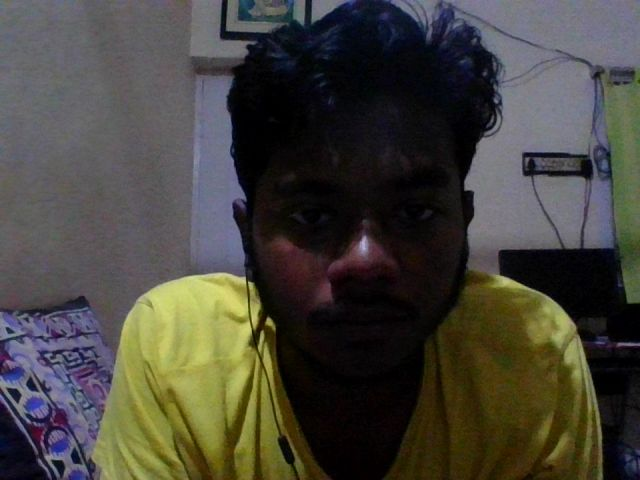

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

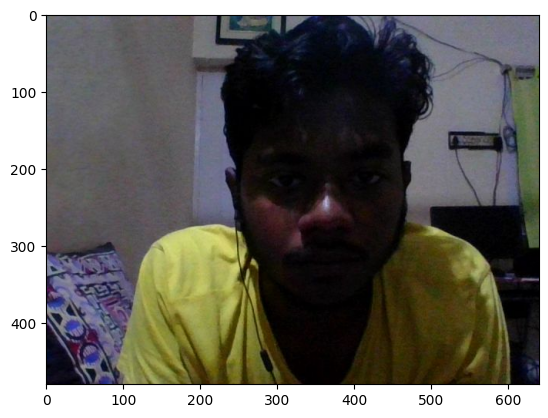

In [ ]:
plt.imshow(plt.imread("input_image.jpg"))

In [ ]:
def genResult(image_path):
  prepare(image_path)
  prediction = model.predict([prepare(image_path)])
  res = labels_new[np.argmax(prediction)]

  cropped_eye = crop_eye(image_path)
  if not cropped_eye:
    return res == 'yawn'

  resized_eye = cv2.resize(cropped_eye, (145, 145))
  normalized_eye = resized_eye / 255.0
  input_data = normalized_eye.reshape(1, 145, 145, 3)
  prediction = model.predict(input_data)
  res2 = labels_new[np.argmax(prediction)]

  if res2 == 'Closed' or res == 'yawn':
    return 1
  return 0





In [ ]:
def generateAlert():
  print("!!!!!!!!!!Alert!!!!!!!!!!")

In [ ]:
image_path = "input_image.jpg"
# image_path = "train/no_yawn/1067.jpg"
if genResult(image_path):
  generateAlert()


1/1 [==============================] - 0s 34ms/step


In [ ]:
# while 1:
#   input_path = "train/no_yawn/1067.jpg"
#   if genResult(image_path):
#    generateAlert()




In [ ]:
prepare("input_image.jpg")
prediction = model.predict([prepare("input_image.jpg")])
res = labels_new[np.argmax(prediction)]
res

1/1 [==============================] - 0s 26ms/step


'Open'